In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sohom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
pip install wordcloud

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [10]:
df2 = pd.read_csv('C://Users//Sohom//Dropbox//Datathon 2021//twitter_dataset.csv')

In [4]:
df3 = pd.read_csv('C://Users//Sohom//Dropbox//Datathon 2021//MHClean.csv')

In [5]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

stop_words = stopwords.words('english')
stop_words.extend(['lol', 'lmao'])

## preprocessing functions 
def decode_emoji(text):
    ''' we can potentially convert emoji to text '''
    text = text.encode('utf-8').decode('unicode escape')
    return text.encode('utf-16','surrogatepass').decode('utf-16')

def emoji2text(text):
    return emoji.demojize(text)

def remove_url(text):
    return re.sub(r"http\S+", "", text)

def remove_pic(text):
    return re.sub(r"pic.\S+", "", text)

def remove_unicode(text):
    return text.encode('ascii', 'ignore').decode('ascii')

def sent2words(sentences):
    ''' tokenize sentences '''
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_model):
    return [bigram_model[doc] for doc in texts]

def make_trigrams(texts, bigram_model, trigram_model):
    return [trigram_model[bigram_model[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """ https://spacy.io/api/annotation """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    
def make_multigram_models(tokenized_data):
    ## Build the bigram and trigram models
    bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=100)  

    ## Faster way to get a sentence clubbed as a trigram/bigram
    bigram_model = gensim.models.phrases.Phraser(bigram)
    trigram_model = gensim.models.phrases.Phraser(trigram)
    return bigram_model, trigram_model

def preprocess(tokenized_data, bigram_model, trigram_model):
    ## remove stopwords 
    data_words_nostops = remove_stopwords(tokenized_data)
    ## form bigrams 
    data_words_bigrams = make_bigrams(data_words_nostops, bigram_model)
    # ## form trigrams 
    # data_words_bigrams = make_trigrams(data_words_nostops, bigram_model, trigram_model)

    ## Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return corpus, id2word

def topic_parser(text,N_words=10):
    text = re.split('; |, |\*|\n|\+|"',text)
    dist = [float(text[i]) for i in np.arange(0,4*N_words,step=4)]
    words = [text[i] for i in np.arange(2,4*N_words,step=4)]
    return words, dist

def sort_topics(lda_model, n_topics=12, n_words=20):
    ''' sort topics by first word probability '''
    list_words = []
    list_dist = np.zeros((n_topics, n_words))

    for i in range(n_topics):
        words, dist = topic_parser(lda_model.print_topics(num_words=n_words)[i][1], N_words=20)
        list_words.append(words)
        list_dist[i,:] = np.array(dist)
    
    ## sort ascend 
    sort_id = np.argsort(list_dist, axis=0)[::-1,:][:,0]
    list_dist_sorted = list_dist[sort_id,:]
    list_words_sorted = [list_words[i] for i in sort_id]
    return list_words_sorted, list_dist_sorted, sort_id

def assign_topic(lda_model, sort_id, corpus_row):
    topic_prob = lda_model[corpus_row]
    topic = max(topic_prob,key=lambda item:item[1])
    topic = np.where(sort_id == topic[0])[0]
    return int(topic) 

def plot_dist(words, dist, title, N_topics=12, N_words=20):
    ''' plot word distrubution for each topic '''
    row = 6
    col = 2
    fig, ax= plt.subplots(nrows=row, ncols=col,figsize=(16,13))
    plt.suptitle(title)

#     words, dist,_ = sort_topics(lda_model, n_topics=N_topics, n_words=N_words)
    counter = 0
    for i in range(row):
        for j in range(col):
#             words, dist = topic_parser(lda_model.print_topics(num_words=N_words)[counter][1], N_words=N_words)
            ax[i,j].bar(np.arange(N_words), dist[counter,:])
            ax[i,j].set_xticks(np.arange(N_words))
            ax[i,j].set_xticklabels(words[counter], rotation=35)
            ax[i,j].set_title('topic {}'.format(counter))
            counter += 1
            if counter >= N_topics: break

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [104]:
a=remove_unicode("don%E2%80%99t know how much longer i can go on")

In [105]:
a

'don%E2%80%99t know how much longer i can go on'

In [108]:
df3

,posts
0,anxiety and depression which one do i hav
1,todays achievements
2,redemption
3,i dont like who i see in the mirror
4,when little to nothing brings you joy
...,...
393,depression due to abusive husband
394,feeling low
395,i have firewalls that protect me
396,terrified of our current future society


In [100]:
data

['anxiety and depression which one do i hav',
 'todays achievements %F0%9F%99%82',
 'redemption',
 'i dont like who i see in the mirror',
 'when little to nothing brings you joy',
 'warning signs',
 '1 thing youre grateful for today',
 'don%E2%80%99t know how much longer i can go on',
 'do you feel guilt of your depression or not',
 'my fate to die',
 'i am not going to sleep this night l',
 'dealing with utter boredom',
 'anyone around',
 'depression since 12 years old',
 'struggling with depression since 5 year',
 'doing better than i have in a long long time',
 'odd feeling better',
 'i truly hate my life more than anything else',
 'lexapro withdrawals only getting wors',
 'lexapro withdrawal symptoms and trying to have some quality of life',
 'social issues anyone else',
 'sick of everything going wrong and ready to jack it all in',
 'the past',
 'what helps you most when youre falling apart',
 'someone talk%EF%BC%9F',
 'i cried today',
 'lyrics that resonate',
 'anxiety and depres

In [6]:
# df = pd.read_csv(file_path, error_bad_lines=False)
data = df3.posts.values.tolist()

data = [decode_emoji(sent) for sent in data]
data = [remove_url(sent) for sent in data]
data = [remove_pic(sent) for sent in data]
data = [remove_unicode(sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['anxiety and depression which one do i hav']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['anxiety', 'and', 'depression', 'which', 'one', 'do', 'hav']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['anxiety', 'and', 'depression', 'which', 'one', 'do', 'hav']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
data_words_nostops = remove_stopwords(data_words)

In [11]:
print(data_words_nostops[:1])

[['anxiety', 'depression', 'one', 'hav']]


In [12]:
type(data_words_nostops)

list

In [13]:
flat_list = [item for sublist in data_words_nostops for item in sublist]

In [14]:
flat_list

['anxiety',
 'depression',
 'one',
 'hav',
 'todays',
 'achievements',
 'redemption',
 'dont',
 'like',
 'see',
 'mirror',
 'little',
 'nothing',
 'brings',
 'joy',
 'warning',
 'signs',
 'thing',
 'youre',
 'grateful',
 'today',
 'dont',
 'know',
 'much',
 'longer',
 'go',
 'feel',
 'guilt',
 'depression',
 'fate',
 'die',
 'going',
 'sleep',
 'night',
 'dealing',
 'utter',
 'boredom',
 'anyone',
 'around',
 'depression',
 'since',
 'years',
 'old',
 'struggling',
 'depression',
 'since',
 'year',
 'better',
 'long',
 'long',
 'time',
 'odd',
 'feeling',
 'better',
 'truly',
 'hate',
 'life',
 'anything',
 'else',
 'lexapro',
 'withdrawals',
 'getting',
 'wors',
 'lexapro',
 'withdrawal',
 'symptoms',
 'trying',
 'quality',
 'life',
 'social',
 'issues',
 'anyone',
 'else',
 'sick',
 'everything',
 'going',
 'wrong',
 'ready',
 'jack',
 'past',
 'helps',
 'youre',
 'falling',
 'apart',
 'someone',
 'talk',
 'cried',
 'today',
 'lyrics',
 'resonate',
 'anxiety',
 'depression',
 'years'

In [37]:
type(df)

pandas.core.frame.DataFrame

In [32]:
type(a)

list

In [50]:
dff=df.sort_values(by=0,ascending=False)
dff.head(100)

,0
0,1


In [85]:
flat_list.remove('brt')
flat_list.remove('rt')

In [119]:
len(flat_list)

1322

In [17]:
ab=list(filter(lambda a: a != 'brt', flat_list))
abcd=list(filter(lambda a: a != 'rt', ab))

In [118]:
df.to_csv('abcde.csv')

In [120]:
# Import package
import matplotlib.pyplot as plt
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [18]:
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele+" "  
    
    # return string  
    return str1 
        
        
# Driver code    
# s = ['Geeks', 'for', 'Geeks']
a=listToString(abcd)

In [19]:
a

'anxiety depression one hav todays achievements redemption dont like see mirror little nothing brings joy warning signs thing youre grateful today dont know much longer go feel guilt depression fate die going sleep night dealing utter boredom anyone around depression since years old struggling depression since year better long long time odd feeling better truly hate life anything else lexapro withdrawals getting wors lexapro withdrawal symptoms trying quality life social issues anyone else sick everything going wrong ready jack past helps youre falling apart someone talk cried today lyrics resonate anxiety depression years old think easier sad new feeling lonely anyone around cant find words year later im back carryng bad feeling everyday vent venlafaxine worries know may seem like nothing loss depression affect judgment anyone experience modafinil depression new treatment depression horrible feeling morning letting beast win sylvia plath bbc four pm uk lost five years hobby stuff sens

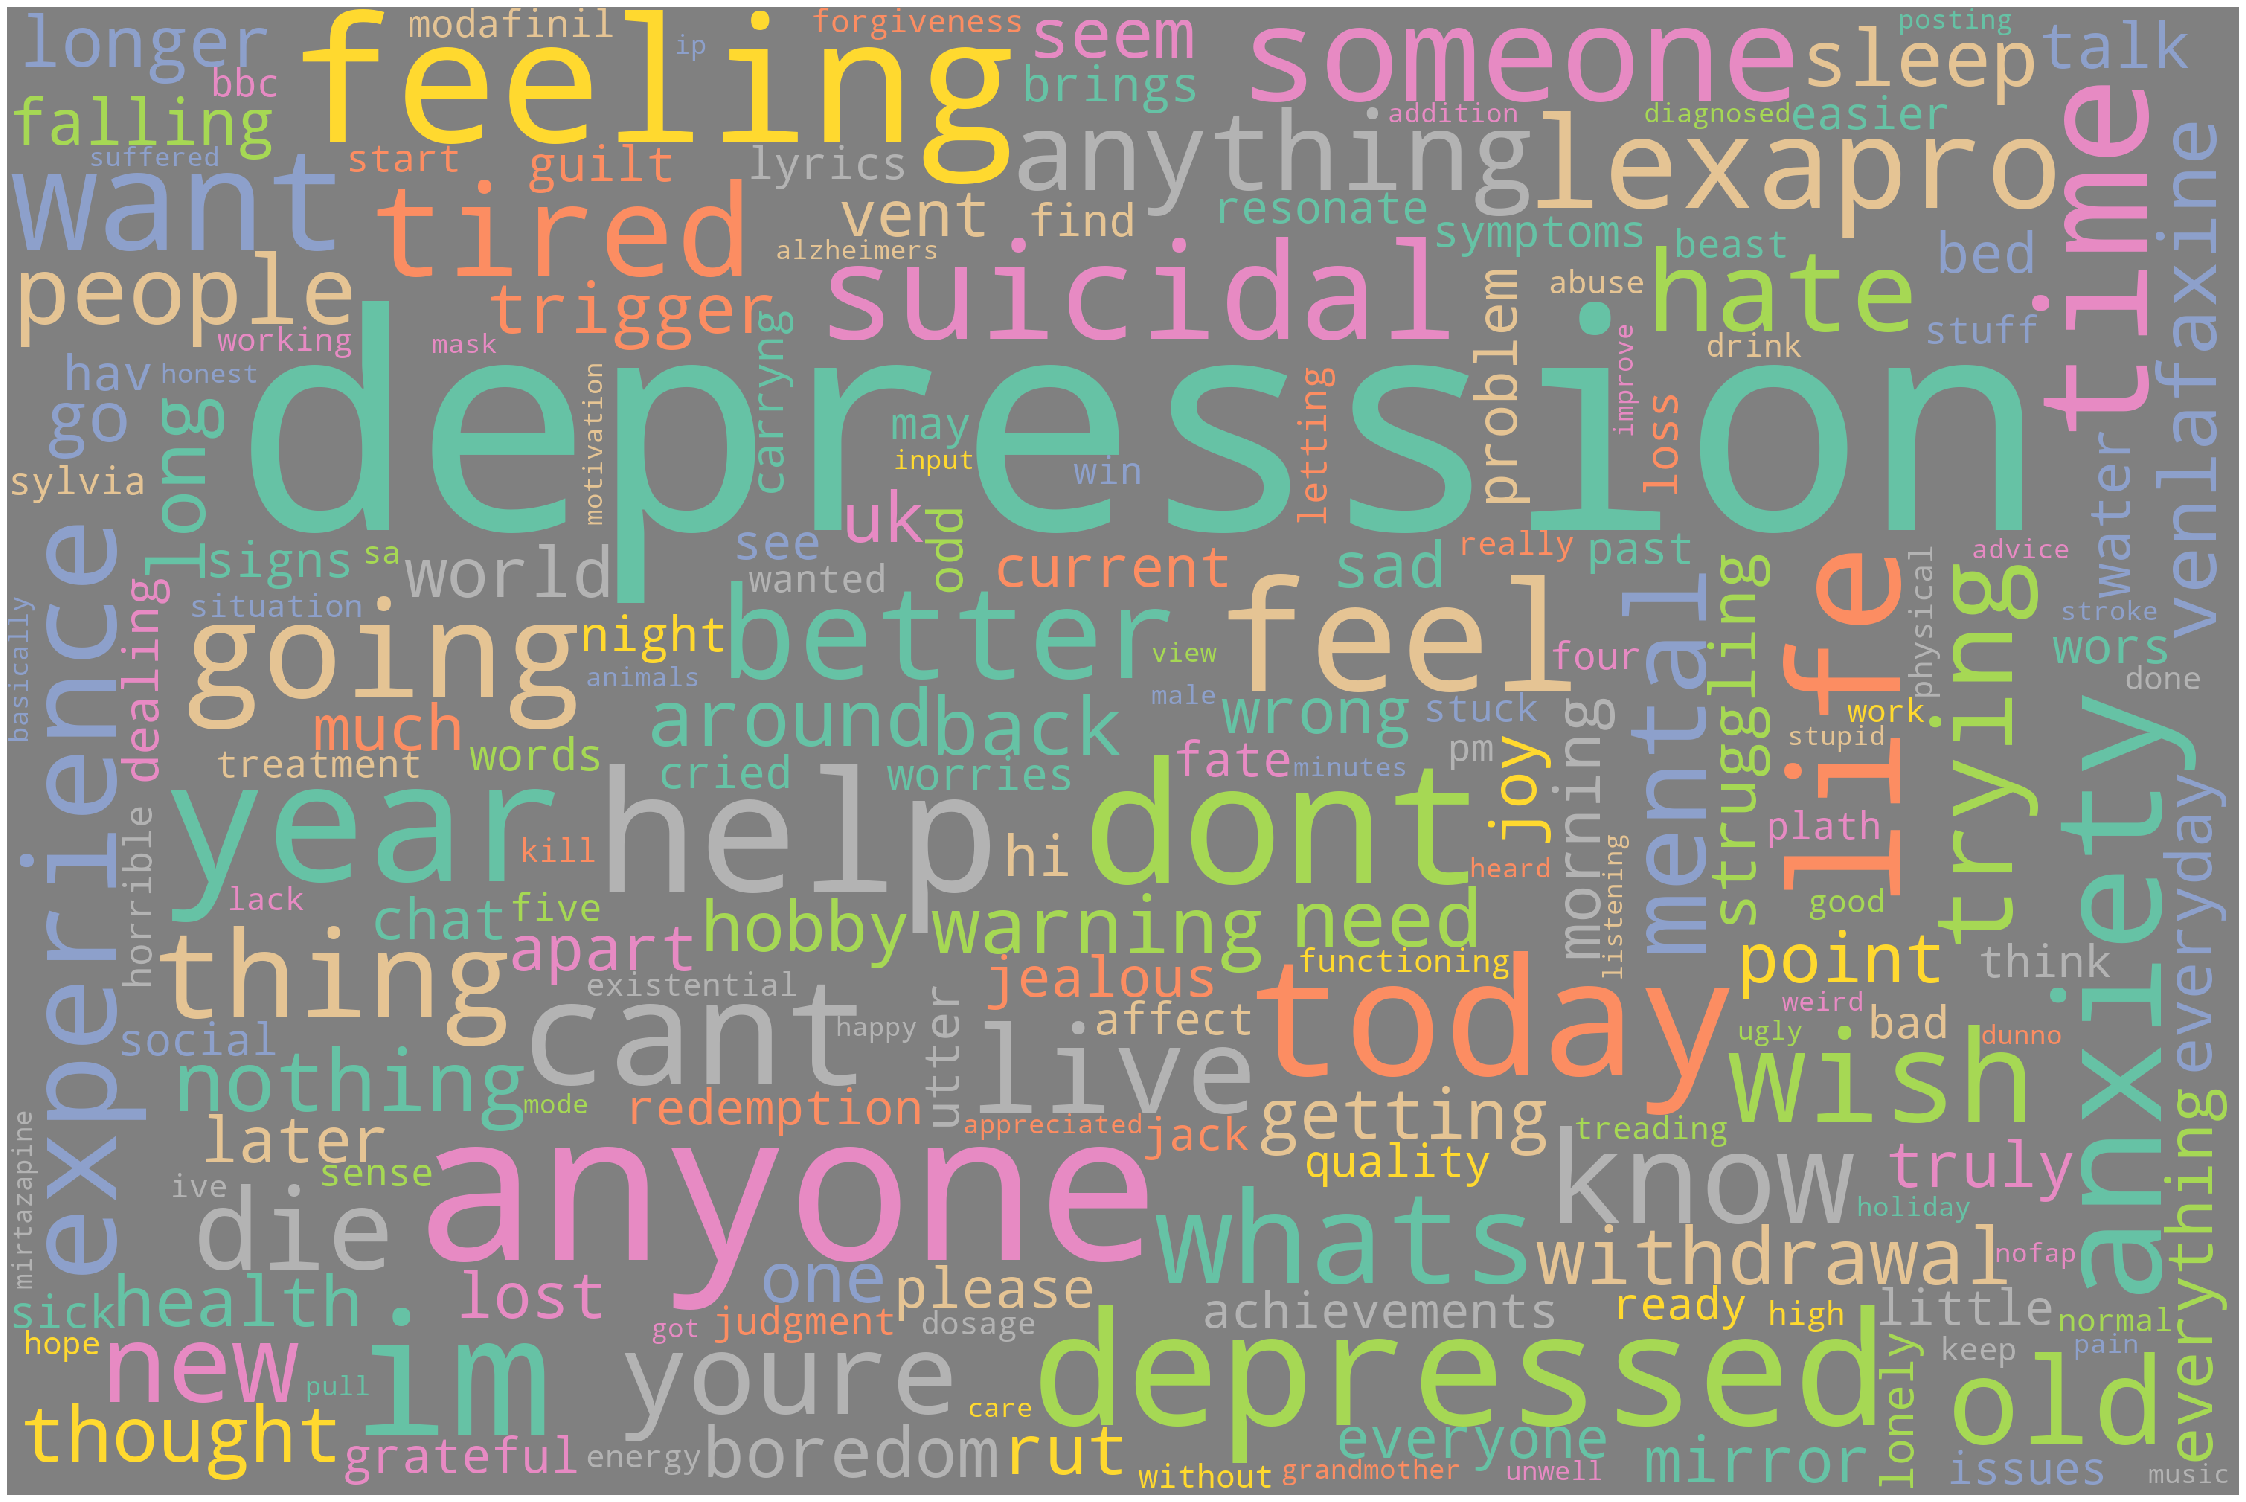

In [123]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='gray', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(a)
# Plot
plot_cloud(wordcloud)

In [125]:
pip install nltk

In [126]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sohom\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [143]:
stringlist=listToString(flat_list)

In [145]:
stringlist=[stringlist]

In [147]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

## Exapmple document (list of sentences)
doc = stringlist

# Tokenization of each document
tokenized_doc = []
for d in doc:
    tokenized_doc.append(word_tokenize(d.lower()))
tokenized_doc

[['anxiety',
  'depression',
  'one',
  'hav',
  'todays',
  'achievements',
  'redemption',
  'dont',
  'like',
  'see',
  'mirror',
  'little',
  'nothing',
  'brings',
  'joy',
  'warning',
  'signs',
  'thing',
  'youre',
  'grateful',
  'today',
  'dont',
  'know',
  'much',
  'longer',
  'go',
  'feel',
  'guilt',
  'depression',
  'fate',
  'die',
  'going',
  'sleep',
  'night',
  'dealing',
  'utter',
  'boredom',
  'anyone',
  'around',
  'depression',
  'since',
  'years',
  'old',
  'struggling',
  'depression',
  'since',
  'year',
  'better',
  'long',
  'long',
  'time',
  'odd',
  'feeling',
  'better',
  'truly',
  'hate',
  'life',
  'anything',
  'else',
  'lexapro',
  'withdrawals',
  'getting',
  'wors',
  'lexapro',
  'withdrawal',
  'symptoms',
  'trying',
  'quality',
  'life',
  'social',
  'issues',
  'anyone',
  'else',
  'sick',
  'everything',
  'going',
  'wrong',
  'ready',
  'jack',
  'past',
  'helps',
  'youre',
  'falling',
  'apart',
  'someone',
  '

In [148]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data

[TaggedDocument(words=['anxiety', 'depression', 'one', 'hav', 'todays', 'achievements', 'redemption', 'dont', 'like', 'see', 'mirror', 'little', 'nothing', 'brings', 'joy', 'warning', 'signs', 'thing', 'youre', 'grateful', 'today', 'dont', 'know', 'much', 'longer', 'go', 'feel', 'guilt', 'depression', 'fate', 'die', 'going', 'sleep', 'night', 'dealing', 'utter', 'boredom', 'anyone', 'around', 'depression', 'since', 'years', 'old', 'struggling', 'depression', 'since', 'year', 'better', 'long', 'long', 'time', 'odd', 'feeling', 'better', 'truly', 'hate', 'life', 'anything', 'else', 'lexapro', 'withdrawals', 'getting', 'wors', 'lexapro', 'withdrawal', 'symptoms', 'trying', 'quality', 'life', 'social', 'issues', 'anyone', 'else', 'sick', 'everything', 'going', 'wrong', 'ready', 'jack', 'past', 'helps', 'youre', 'falling', 'apart', 'someone', 'talk', 'cried', 'today', 'lyrics', 'resonate', 'anxiety', 'depression', 'years', 'old', 'think', 'easier', 'sad', 'new', 'feeling', 'lonely', 'anyone

In [149]:
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)
# Save trained doc2vec model
model.save("test_doc2vec.model")
## Load saved doc2vec model
model= Doc2Vec.load("test_doc2vec.model")
## Print model vocabulary
model.wv.vocab

{'anxiety': <gensim.models.keyedvectors.Vocab at 0x1fc40794c88>,
 'depression': <gensim.models.keyedvectors.Vocab at 0x1fc40794cc8>,
 'one': <gensim.models.keyedvectors.Vocab at 0x1fc40794d48>,
 'hav': <gensim.models.keyedvectors.Vocab at 0x1fc40794dc8>,
 'todays': <gensim.models.keyedvectors.Vocab at 0x1fc40794e48>,
 'achievements': <gensim.models.keyedvectors.Vocab at 0x1fc40794ec8>,
 'redemption': <gensim.models.keyedvectors.Vocab at 0x1fc40794fc8>,
 'dont': <gensim.models.keyedvectors.Vocab at 0x1fc40795088>,
 'like': <gensim.models.keyedvectors.Vocab at 0x1fc40795108>,
 'see': <gensim.models.keyedvectors.Vocab at 0x1fc40795188>,
 'mirror': <gensim.models.keyedvectors.Vocab at 0x1fc40795208>,
 'little': <gensim.models.keyedvectors.Vocab at 0x1fc40795288>,
 'nothing': <gensim.models.keyedvectors.Vocab at 0x1fc40795308>,
 'brings': <gensim.models.keyedvectors.Vocab at 0x1fc40795388>,
 'joy': <gensim.models.keyedvectors.Vocab at 0x1fc40795408>,
 'warning': <gensim.models.keyedvectors.

In [150]:
test_doc = word_tokenize("i want to die".lower())

In [154]:
pip install spacy

In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [20]:
ref_vec=nlp(a)

In [79]:
b="i am feeling funny"

In [80]:
c=nlp(b)

In [81]:
c.similarity(ref_vec)

C:\Users\Sohom\Anaconda3\lib\runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


0.43337170649309265